# Import Important Packages

In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
import os, random

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.10.0


# Check GPU Available

In [2]:
print("GPU Available: ", tf.config.list_physical_devices("GPU"))
!nvidia-smi -L

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU (UUID: GPU-509cf0ce-8a5d-aa4a-fa20-6093938c3e7e)


# Exploratory Data Analyst

Dataset ini diekspor melalui [universe.roboflow.com](https://universe.roboflow.com/palm-fruit-classification/palm-fruit-ripeness-classificationcnn) pada 23 September 2023 pukul 04.36 GMT

Kumpulan data mencakup 3024 gambar.
Buah sawit dalam format klip.

Pra-pemrosesan berikut diterapkan pada setiap gambar:
* Orientasi otomatis data piksel (dengan stripping orientasi EXIF)
* Ubah ukuran menjadi 299x299 (Peregangan)

In [3]:
train_path = "G:/My Drive/Dataset/Tomato Dataset"
images_path = glob(train_path + "/*/*.jp*g")
classname = os.listdir(train_path).sort()

## View Image Randomly

Image Shape:  (256, 256, 3)
G:/My Drive/Dataset/Tomato Dataset\Gangguan Tungau Merah dan Tungah Laba-Laba\ff6346ca-227b-4cb4-a350-0941048744fa___Com.G_SpM_FL 9338_final_masked.jpg


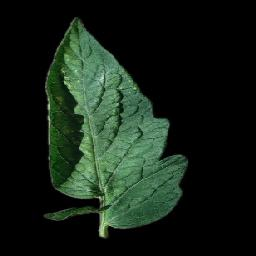

In [17]:
from IPython.display import Image
import matplotlib.image as mpimg

random_image = random.choice(images_path)
print("Image Shape: ", mpimg.imread(random_image).shape)
print(random_image)
Image(random_image)

# Get Dataset From Directory

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(validation_split=0.2,
                             rotation_range = 90,
                             brightness_range = [0.5, 1.0],
                             zoom_range = [0.5, 1.0])

train_data = datagen.flow_from_directory(train_path,
                                        target_size = (224, 224),
                                        subset = "training",
                                        shuffle = True)

val_data = datagen.flow_from_directory(train_path,
                                      target_size = (224, 224),
                                      subset = 'validation',
                                      shuffle = False)

Found 14532 images belonging to 10 classes.
Found 3628 images belonging to 10 classes.


In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime

logdir = "../Logs/potato/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

early_stopping = EarlyStopping(monitor = "val_accuracy",
                               patience = 10,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              mode = 'max',
                              factor = 0.2,
                              patience = 2,
                              min_lr=1e-5)

tensorboard = TensorBoard(logdir)

# Creating a MobileNet Architecture Model

In [7]:
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import Model
checkpoint_path = "../Checkpoint/corn/potato-mobilenetv3small-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".ckpt"

base_model = MobileNetV3Small(input_shape = (224, 224, 3),
                              minimalistic = True,
                              include_top = False)
mobilenet_preprocessor = preprocess_input
for layer in base_model.layers:
  layer.trainable = True

input = Input(shape = (224, 224, 3))
prep_input = mobilenet_preprocessor(input)
x = base_model(prep_input)
x = Flatten()(x)
output = Dense(3, activation = "softmax")(x)

model = Model(inputs = input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        441000    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 3)                 84675     
                                                                 
Total params: 525,675
Trainable params: 513,563
Non-trainable params: 12,112
_________________________________________________________________


In [29]:
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import Model
checkpoint_path = "../Checkpoint/corn/potato-vgg16-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".ckpt"

base_model = VGG16(include_top = False)
mobilenet_preprocessor = preprocess_input
for layer in base_model.layers:
  layer.trainable = True

input = Input(shape = (224, 224, 3))
prep_input = mobilenet_preprocessor(input)
x = base_model(prep_input)
x = Flatten()(x)
output = Dense(3, activation = "softmax")(x)

model = Model(inputs = input, outputs=output)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 3)                 7526

# Compile the Model

In [8]:
model.compile(loss ="categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [9]:
history = model.fit(train_data,
                    validation_data = val_data,
                    epochs = 100,
                    steps_per_epoch = len(train_data),
                    validation_steps = len(val_data),
                    callbacks = [early_stopping, reduce_lr, tensorboard])

model.save_weights(checkpoint_path)

Epoch 1/100
82/82 [==============================] - 90s 1s/step - loss: 0.5967 - accuracy: 0.8751 - val_loss: 9.4185 - val_accuracy: 0.5701 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 52s 635ms/step - loss: 0.3513 - accuracy: 0.9435 - val_loss: 1.8724 - val_accuracy: 0.8490 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 93s 1s/step - loss: 0.1569 - accuracy: 0.9650 - val_loss: 1.9284 - val_accuracy: 0.8259 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 108s 1s/step - loss: 0.1579 - accuracy: 0.9585 - val_loss: 3.5788 - val_accuracy: 0.8059 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 113s 1s/step - loss: 0.1172 - accuracy: 0.9681 - val_loss: 2.6052 - val_accuracy: 0.8398 - lr: 2.0000e-04
Epoch 6/100
82/82 [==============================] - 67s 811ms/step - loss: 0.0872 - accuracy: 0.9743 - val_loss: 1.7317 - val_accuracy: 0.8783 - lr: 2.0000e-04
Epoch 7/100
82/82 [==============================] - 90s 1s/

In [10]:
model.evaluate(val_data)

21/21 [==============================] - 23s 1s/step - loss: 0.2377 - accuracy: 0.9507


[0.23773330450057983, 0.9506933689117432]

# View the Training Graph

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "G:/My Drive/Colab Notebooks/Checkpoint/palm/" --port=8008

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Load Checkpoint

In [ ]:
model.load_weights("C:/Users/salma/pyworkspace/Checkpoint/potato/potato-mobilenetv3small-20231015-222128.ckpt")
model.evaluate(val_data)

21/21 [==============================] - 10s 128ms/step - loss: 0.0849 - accuracy: 0.9892


[0.08488154411315918, 0.989230751991272]

# Evaluate

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [ ]:
y_pred = np.array([])
y_val =  np.array([])
for x, y in val_data:
  y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis = -1)])
  y_val = np.concatenate([y_val, np.argmax(y, axis=-1)])

1/1 [==============================] - 0s 19ms/step


## Confusion Matrix

Confusion Matrix, Without Normalization
[[218   0   1]
 [  1 250   3]
 [  1   1 175]]


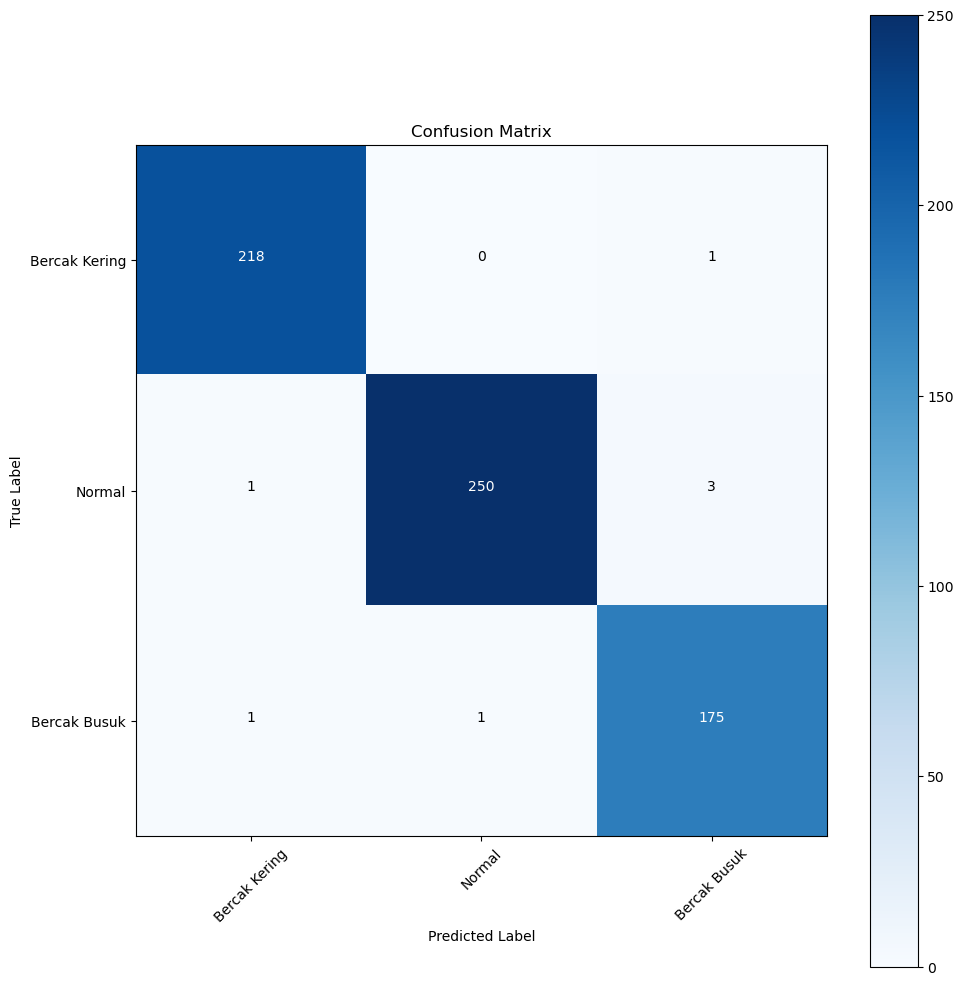

In [ ]:
cm = confusion_matrix(y_val, y_pred)
plot_confusion_matrix(cm = cm, classes = classname)

## Classification Report

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       219
         1.0       1.00      0.98      0.99       254
         2.0       0.98      0.99      0.98       177

    accuracy                           0.99       650
   macro avg       0.99      0.99      0.99       650
weighted avg       0.99      0.99      0.99       650



1/1 [==============================] - 0s 14ms/step


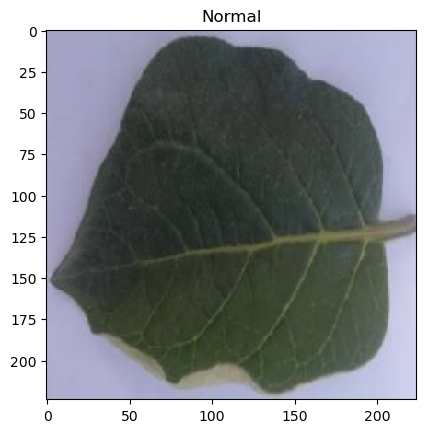

In [ ]:
from tensorflow.keras.preprocessing import image

random_image = random.choice(images_path)
images = image.load_img(random_image, target_size=(224, 224))
x = image.img_to_array(images)
x = np.expand_dims(x, axis = 0)
img = np.vstack([x])
classes = model.predict(img)
implot = plt.imshow(images)
plt.title(classname[np.argmax(classes)]);

In [ ]:
classname.sort()
classname

['Bercak Busuk', 'Bercak Kering', 'Normal']